# Viscosity-based filtering with vector Laplacians

In this tutorial, we use **viscosity-based filters** to filter a velocity field $(u,v)$ on a curvilinear grid. The viscosity-based filter uses a **vector Laplacian** (rather than a scalar Laplacian).

In [1]:
import gcm_filters
import numpy as np
import xarray as xr

Here are all grid types that we have available.

In [2]:
list(gcm_filters.GridType)

[<GridType.REGULAR: 1>,
 <GridType.REGULAR_WITH_LAND: 2>,
 <GridType.IRREGULAR_WITH_LAND: 3>,
 <GridType.TRIPOLAR_REGULAR_WITH_LAND: 4>,
 <GridType.TRIPOLAR_POP_WITH_LAND: 5>,
 <GridType.VECTOR_C_GRID: 6>]

From this list, only the `VECTOR_C_GRID` has a vector Laplacian. All other grid types operate with scalar Laplacians. As the name suggests, the `VECTOR_C_GRID` works for vector fields that are defined on an **Arakawa C-grid**, where the u-component is defined at the center of the eastern cell edge, and the v-component at the center of the northern cell edge.

## 0.1 degree MOM6 data

We are working with MOM6 data from a 0.1 degree simulation on an Arakawa **C-grid**. The `VECTOR_C_GRID` type is therefore suitable for our data!

In [3]:
ds = xr.open_dataset('/glade/scratch/gmarques/for_nora/g.c2b6.GJRA.TL319_t13.control_mct.003.mom6.sfc_0022_01.nc', decode_times=False)
ds

<xarray.Dataset>
Dimensions:       (nv: 2, time: 31, xh: 3600, xq: 3600, yh: 2400, yq: 2400)
Coordinates:
  * xh            (xh) float64 -109.9 -109.8 -109.8 ... -110.2 -110.2 -110.1
  * yh            (yh) float64 -78.47 -78.43 -78.39 -78.35 ... 89.88 89.92 89.97
  * time          (time) float64 7.666e+03 7.666e+03 ... 7.694e+03 7.696e+03
  * nv            (nv) float64 1.0 2.0
  * xq            (xq) float64 -109.9 -109.8 -109.7 ... -110.2 -110.1 -110.0
  * yq            (yq) float64 -78.45 -78.41 -78.37 -78.32 ... 89.9 89.95 90.0
Data variables:
    SSH           (time, yh, xh) float32 ...
    tos           (time, yh, xh) float32 ...
    sos           (time, yh, xh) float32 ...
    SSU           (time, yh, xq) float32 ...
    SSV           (time, yq, xh) float32 ...
    mass_wt       (time, yh, xh) float32 ...
    opottempmint  (time, yh, xh) float32 ...
    somint        (time, yh, xh) float32 ...
    Rd_dx         (time, yh, xh) float32 ...
    speed         (time, yh, xh) float32 ...
    mlotst        (time, yh, xh) float32 ...
    oml           (time, yh, xh) float32 ...
    average_T1    (time) float64 ...
    average_T2    (time) float64 ...
    average_DT    (time) float64 ...
    time_bnds     (time, nv) float64 ...
Attributes:
    filename:          combined/g.c2b6.GJRA.TL319_t13.control_mct.003.mom6.sf...
    title:             MOM6 diagnostic fields table for CESM case: g.c2b6.GJR...
    associated_files:  area_t: g.c2b6.GJRA.TL319_t13.control_mct.003.mom6.sta...
    grid_type:         regular
    grid_tile:         N/A
    history:           20201204T1851Z: mppnccombine-fast --output combined/g....

The next dataset contains all necessary information on our grid.

In [4]:
ds_static = xr.open_dataset('/glade/scratch/gmarques/for_nora/g.c2b6.GJRA.TL319_t13.control_mct.003.mom6.static.nc', decode_times=False)
ds_static

<xarray.Dataset>
Dimensions:      (time: 1, xh: 3600, xq: 3600, yh: 2400, yq: 2400)
Coordinates:
  * xh           (xh) float64 -109.9 -109.8 -109.8 ... -110.2 -110.2 -110.1
  * yh           (yh) float64 -78.47 -78.43 -78.39 -78.35 ... 89.88 89.92 89.97
  * time         (time) float64 0.0
  * xq           (xq) float64 -109.9 -109.8 -109.7 ... -110.2 -110.1 -110.0
  * yq           (yq) float64 -78.45 -78.41 -78.37 -78.32 ... 89.9 89.95 90.0
Data variables:
    geolon       (yh, xh) float32 ...
    geolat       (yh, xh) float32 ...
    geolon_c     (yq, xq) float32 ...
    geolat_c     (yq, xq) float32 ...
    geolon_u     (yh, xq) float32 ...
    geolat_u     (yh, xq) float32 ...
    geolon_v     (yq, xh) float32 ...
    geolat_v     (yq, xh) float32 ...
    dyCu         (yh, xq) float32 ...
    dxCv         (yq, xh) float32 ...
    dxCu         (yh, xq) float32 ...
    dyCv         (yq, xh) float32 ...
    area_t       (yh, xh) float32 ...
    depth_ocean  (yh, xh) float32 ...
    wet          (yh, xh) float32 ...
    wet_c        (yq, xq) float32 ...
    wet_u        (yh, xq) float32 ...
    wet_v        (yq, xh) float32 ...
    Coriolis     (yq, xq) float32 ...
Attributes:
    filename:   combined/g.c2b6.GJRA.TL319_t13.control_mct.003.mom6.static.nc
    title:      MOM6 diagnostic fields table for CESM case: g.c2b6.GJRA.TL319...
    grid_type:  regular
    grid_tile:  N/A
    history:    20210528T1522Z: mppnccombine-fast --output combined/g.c2b6.GJ...

## Preparing the grid info
These are the grid variables that our vector Laplacian needs to know.

In [5]:
gcm_filters.required_grid_vars(gcm_filters.GridType.VECTOR_C_GRID)

['wet_mask_t',
 'wet_mask_q',
 'dxT',
 'dyT',
 'dxCu',
 'dyCu',
 'dxCv',
 'dyCv',
 'dxBu',
 'dyBu',
 'area_u',
 'area_v',
 'kappa_iso',
 'kappa_aniso']

`dxT`, `dyT`, `dxBu`, and `dyBu` are grid lengths centered at T-points and vorticity points respectively. `ds_static` doesn't hold these grid variables, but we can compute them (approximately) thanks to the [xgcm package](https://xgcm.readthedocs.io/en/latest/grids.html). (**Note**: Would be better if we had them directly available.)

In [6]:
from xgcm import Grid
coords = {'X': {'center': 'xh', 'right': 'xq'},
            'Y': {'center': 'yh', 'right': 'yq'}
         }
grid = Grid(ds_static, coords=coords, periodic=['X']) 

ds_static['dxT'] = grid.interp(ds_static.dxCu,'X')
ds_static['dyT'] = grid.interp(ds_static.dyCv,'Y',boundary='fill')
ds_static['dxBu'] = grid.interp(ds_static.dxCv,'X')
ds_static['dyBu'] = grid.interp(ds_static.dyCu,'Y',boundary='fill')

We are now ready to define all grid input variables for our vector Laplacian.

In [7]:
# grid info centered at T-points
wet_mask_t = ds_static.wet
dxT = ds_static.dxT
dyT = ds_static.dyT
# grid info centered at U-points
dxCu = ds_static.dxCu.swap_dims({"xq": "xh"})
dyCu = ds_static.dyCu.swap_dims({"xq": "xh"})
area_u = dxCu * dyCu
# grid info centered at V-points
dxCv = ds_static.dxCv.swap_dims({"yq": "yh"})
dyCv = ds_static.dyCv.swap_dims({"yq": "yh"})
area_v = dxCv * dyCv
# grid info centered at vorticity points
wet_mask_q = ds_static.wet_c.swap_dims({"xq": "xh", "yq": "yh"})
dxBu = ds_static.dxBu.swap_dims({"xq": "xh", "yq": "yh"})
dyBu = ds_static.dyBu.swap_dims({"xq": "xh", "yq": "yh"})

In the previous cell, we renamed the `xq` and `yq` dimensions so that all grid variables have the same dimensions: `xh`, `yh`. 

Next, we compute the minimum and maximum grid spacing.

In [8]:
dx_min = min(dxT.where(wet_mask_t).min(), dyT.where(wet_mask_t).min())
dx_min = dx_min.values
dx_min

array(2245.78271484)

In [9]:
dx_max = max(dxT.max(), dyT.max(), dxCu.max(), dyCu.max(), dxCv.max(), dyCv.max(), dxBu.max(), dyBu.max())
dx_max = dx_max.values
dx_max

array(11260.51171875)

## Viscosity-based filtering with fixed length scale

First, we want to filter velocity with a **fixed filter length scale of 100 km**. That is, we use a filter that attempts to remove scales smaller than 100 km. 

In [10]:
filter_scale = 100000

Since we don't want to vary the filter scale spatially and we are happy with an isotropic filter, we set `kappa_iso` equal to 1 and `kappa_aniso` equal to 0 over the full domain.

In [11]:
kappa_iso = xr.ones_like(dxT)
kappa_aniso = xr.zeros_like(dyT)

### Creating the filter

We now create our filter.

In [12]:
filter_visc_100km = gcm_filters.Filter(
    filter_scale=filter_scale,
    dx_min=dx_min,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.VECTOR_C_GRID,
    grid_vars={
        'wet_mask_t': wet_mask_t, 'wet_mask_q': wet_mask_q,
        'dxT': dxT, 'dyT': dyT, 
        'dxCu': dxCu, 'dyCu': dyCu, 'area_u': area_u, 
        'dxCv': dxCv, 'dyCv': dyCv, 'area_v': area_v,
        'dxBu': dxBu, 'dyBu': dyBu,
        'kappa_iso': kappa_iso, 'kappa_aniso': kappa_aniso
    }
)
filter_visc_100km

Filter(filter_scale=100000, dx_min=array(2245.78271484), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=49, grid_type=<GridType.VECTOR_C_GRID: 6>)

### Filtering velocity

We now filter our velocity vector field lazily. In contrast to the diffusion-based filters, the viscosity-based filter **takes a vector field** (here: $(u,v)$) **as input** and **returns a vector field**. 

In [13]:
ds_tmp = xr.Dataset()  # temporary dataset with swapped dimensions
ds_tmp['u'] = ds['SSU']
ds_tmp['v'] = ds['SSV']
ds_tmp['u'] = ds_tmp['u'].swap_dims({'xq':'xh'})
ds_tmp['v'] = ds_tmp['v'].swap_dims({'yq':'yh'})

Below, we will only be interested in plotting the filtered velocity data from a single time slice and a single layer. We can therefore make things more efficient if we first rechunk our Dask array in such a way that each chunk contains only a 2D field.

In [14]:
ds_tmp = ds_tmp.chunk({'time': 1})

In [15]:
ds_tmp.u

<xarray.DataArray 'u' (time: 31, yh: 2400, xh: 3600)>
dask.array<xarray-u, shape=(31, 2400, 3600), dtype=float32, chunksize=(1, 2400, 3600), chunktype=numpy.ndarray>
Coordinates:
  * yh       (yh) float64 -78.47 -78.43 -78.39 -78.35 ... 89.88 89.92 89.97
  * xh       (xh) float64 -109.9 -109.8 -109.8 -109.7 ... -110.2 -110.2 -110.1
  * time     (time) float64 7.666e+03 7.666e+03 ... 7.694e+03 7.696e+03
Attributes:
    long_name:      Sea Surface Zonal Velocity
    units:          m s-1
    cell_methods:   yh:mean xq:point time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    interp_method:  none

In [16]:
ds_tmp.v

<xarray.DataArray 'v' (time: 31, yh: 2400, xh: 3600)>
dask.array<xarray-v, shape=(31, 2400, 3600), dtype=float32, chunksize=(1, 2400, 3600), chunktype=numpy.ndarray>
Coordinates:
  * yh       (yh) float64 -78.47 -78.43 -78.39 -78.35 ... 89.88 89.92 89.97
  * xh       (xh) float64 -109.9 -109.8 -109.8 -109.7 ... -110.2 -110.2 -110.1
  * time     (time) float64 7.666e+03 7.666e+03 ... 7.694e+03 7.696e+03
Attributes:
    long_name:      Sea Surface Meridional Velocity
    units:          m s-1
    cell_methods:   yq:point xh:mean time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    interp_method:  none

In [17]:
(u_filtered, v_filtered) = filter_visc_100km.apply_to_vector(ds_tmp.u, ds_tmp.v, dims=['yh', 'xh'])

We now swap back the dimensions.

In [18]:
ds_tmp['u_filtered'] = u_filtered
ds_tmp['u_filtered'] = ds_tmp['u_filtered'].swap_dims({'xh':'xq'})

ds_tmp['v_filtered'] = v_filtered
ds_tmp['v_filtered'] = ds_tmp['v_filtered'].swap_dims({'yh':'yq'})

### Plotting

In [19]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'font.size': 16}
pylab.rcParams.update(params)
import matplotlib.ticker as mticker
import cartopy.crs as ccrs

We want to plot the filtered velocities for the first time slice. Let's trigger computation.

In [20]:
%time u_filtered = ds_tmp.u_filtered.isel(time=0).compute()
%time v_filtered = ds_tmp.v_filtered.isel(time=0).compute()

CPU times: user 21.7 s, sys: 17.2 s, total: 38.9 s
Wall time: 39.5 s
CPU times: user 21.6 s, sys: 17.5 s, total: 39.1 s
Wall time: 39.3 s


To be able to plot unfiltered and filterd using true longitude and latitude, we need to make geolon/geolat coordinates of our xarray.Datasets.

In [21]:
u = ds['SSU'].isel(time=0).where(ds_static.wet_u).assign_coords({'geolat': ds_static['geolat_u'], 'geolon': ds_static['geolon_u']})
v = ds['SSV'].isel(time=0).where(ds_static.wet_v).assign_coords({'geolat': ds_static['geolat_v'], 'geolon': ds_static['geolon_v']})

In [22]:
u_filtered = u_filtered.where(ds_static.wet_u).assign_coords({'geolat': ds_static['geolat_u'], 'geolon': ds_static['geolon_u']})
v_filtered = v_filtered.where(ds_static.wet_v).assign_coords({'geolat': ds_static['geolat_v'], 'geolon': ds_static['geolon_v']})

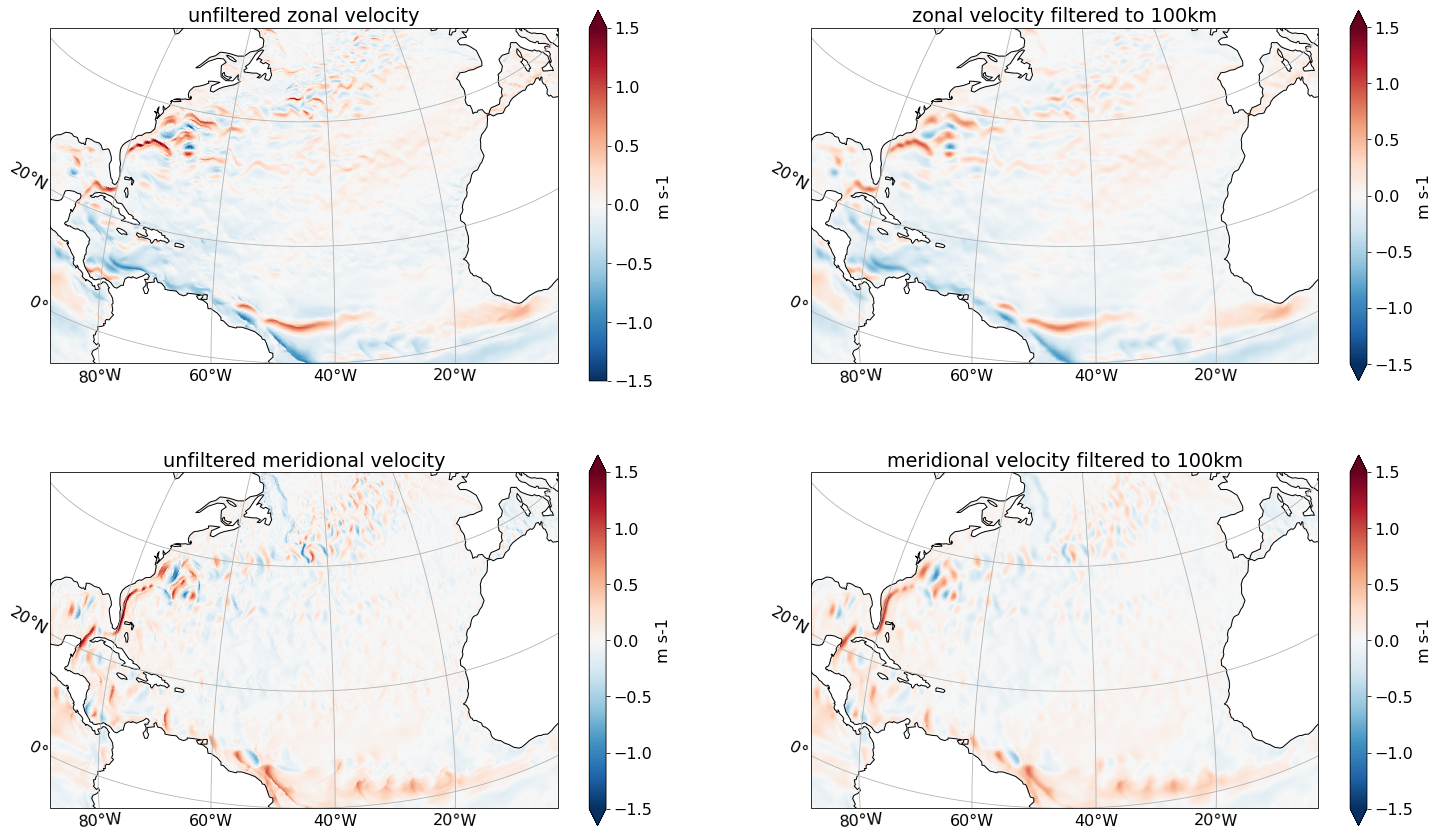

In [24]:
vmax = 1.5
central_lon = -45
central_lat = 30

fig,axs = plt.subplots(2,2,figsize=(25,15),subplot_kw={'projection':ccrs.Orthographic(central_lon, central_lat)})

u.plot(
    ax=axs[0,0], x='geolon', y='geolat', vmin=-vmax, vmax=vmax, 
    cmap='RdBu_r', cbar_kwargs={'label': 'm s-1'},
    transform=ccrs.PlateCarree()
)
v.plot(
    ax=axs[1,0], x='geolon', y='geolat', vmin=-vmax, vmax=vmax, 
    cmap='RdBu_r', cbar_kwargs={'label': 'm s-1'},
    transform=ccrs.PlateCarree()
)
u_filtered.plot(
    ax=axs[0,1], x='geolon', y='geolat', vmin=-vmax, vmax=vmax, 
    cmap='RdBu_r', cbar_kwargs={'label': 'm s-1'},
    transform=ccrs.PlateCarree()
)
v_filtered.plot(
    ax=axs[1,1], x='geolon', y='geolat', vmin=-vmax, vmax=vmax, 
    cmap='RdBu_r', cbar_kwargs={'label': 'm s-1'},
    transform=ccrs.PlateCarree()
)

axs[0,0].set(title='unfiltered zonal velocity')
axs[0,1].set(title='zonal velocity filtered to 100km')
axs[1,0].set(title='unfiltered meridional velocity')
axs[1,1].set(title='meridional velocity filtered to 100km')

for ax in axs.flatten():
    ax.coastlines()
    ax.set_extent([-90, 0, 0, 50], crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True)
    gl.xlocator = mticker.FixedLocator([-80,-60,-40,-20])
    gl.ylocator = mticker.FixedLocator([0,20,40,60])
    gl.top_labels = False
    gl.right_labels = False


## Viscosity-based filtering with fixed filter factor

In our second example, we want to filter velocity with a **fixed filter factor of 10**. That is, our goal is to use a filter that removes scales smaller than **10 times the local grid scale**. 
The fixed factor filter is a **spatially-varying & anisotropic filter**. Consistent with the MOM6 implementation of anisotropic viscosity, the conventions for the `VECTOR_C_GRID` Laplacian are:
* `kappa_iso` is the isotropic viscosity,
* `kappa_aniso` is the additive anisotropy that is aligned with x-direction,

resulting in `kappa_x = kappa_iso` and `kappa_y = kappa_iso + kappa_aniso`. Anisotropy in an arbitrary direction (not aligned with the grid directions) is not yet implemented for `VECTOR_C_GRID`, but could be added mimicking the implementation in MOM6 (following [Smith and McWilliams, 2003](https://www.sciencedirect.com/science/article/pii/S1463500302000161?via%3Dihub)). 

These are the filter specs for the viscosity-based fixed factor filter (similar as for the diffusion-based *fixed factor* filter in [this tutorial](https://gcm-filters.readthedocs.io/en/latest/tutorial_filter_types.html)). 

In [25]:
filter_scale = 10 * dx_max
kappa_iso = dyCv * dyCv / (dx_max * dx_max)
kappa_aniso = dxCu*dxCu / (dx_max * dx_max) - dyCv * dyCv / (dx_max * dx_max)

The filter needs: $0 < \kappa_{iso} \leq 1$ and $0 < \kappa_{iso} + \kappa_{aniso} \leq 1$. These requirements are satisfied as shown in the next plot.

In [26]:
kappa_iso = kappa_iso.where(wet_mask_t).assign_coords({'geolat': ds_static['geolat'], 'geolon': ds_static['geolon']})
kappa_aniso = kappa_aniso.where(wet_mask_t).assign_coords({'geolat': ds_static['geolat'], 'geolon': ds_static['geolon']})

/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)


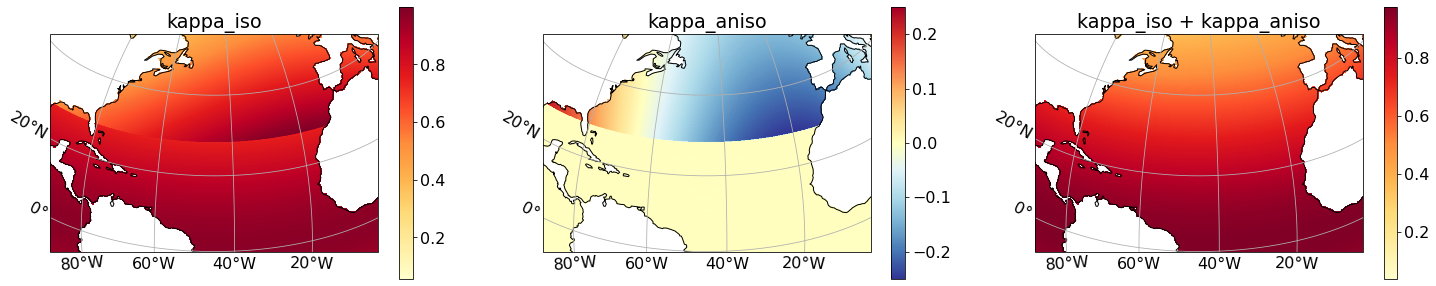

In [28]:
fig,axs = plt.subplots(1,3,figsize=(25,5),subplot_kw={'projection':ccrs.Orthographic(central_lon, central_lat)})

kappa_iso.plot(
    ax=axs[0], x='geolon', y='geolat', cmap='YlOrRd', cbar_kwargs={'label': ''},
    transform=ccrs.PlateCarree()
)
kappa_aniso.plot(
    ax=axs[1], x='geolon', y='geolat', cmap='RdYlBu_r', cbar_kwargs={'label': ''},
    transform=ccrs.PlateCarree()
)
(kappa_iso + kappa_aniso).plot(
    ax=axs[2], x='geolon', y='geolat', cmap='YlOrRd', cbar_kwargs={'label': ''},
    transform=ccrs.PlateCarree()
)

axs[0].set(title='kappa_iso')
axs[1].set(title='kappa_aniso')
axs[2].set(title='kappa_iso + kappa_aniso')

for ax in axs.flatten():
    ax.coastlines()
    ax.set_extent([-90, 0, 0, 50], crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True)
    gl.xlocator = mticker.FixedLocator([-80,-60,-40,-20])
    gl.ylocator = mticker.FixedLocator([0,20,40,60])
    gl.top_labels = False
    gl.right_labels = False


We now create our fixed factor filter.

In [29]:
filter_fac10 = gcm_filters.Filter(
    filter_scale=filter_scale,
    dx_min=dx_min,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.VECTOR_C_GRID,
    grid_vars={'wet_mask_t': wet_mask_t, 'wet_mask_q': wet_mask_q,
                'dxT': dxT, 'dyT': dyT, 
               'dxCu': dxCu, 'dyCu': dyCu, 'area_u': area_u, 
               'dxCv': dxCv, 'dyCv': dyCv, 'area_v': area_v,
               'dxBu': dxBu, 'dyBu': dyBu,
               'kappa_iso': kappa_iso, 'kappa_aniso': kappa_aniso
              }
)
filter_fac10

Filter(filter_scale=112605.1171875, dx_min=array(2245.78271484), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=56, grid_type=<GridType.VECTOR_C_GRID: 6>)

We filter surface velocities with the fixed factor filter...

In [30]:
(u_filtered_fac10, v_filtered_fac10) = filter_fac10.apply_to_vector(ds_tmp.u, ds_tmp.v, dims=['yh', 'xh'])

In [31]:
ds_tmp['u_filtered_fac10'] = u_filtered_fac10
ds_tmp['u_filtered_fac10'] = ds_tmp['u_filtered_fac10'].swap_dims({'xh':'xq'})

ds_tmp['v_filtered_fac10'] = v_filtered_fac10
ds_tmp['v_filtered_fac10'] = ds_tmp['v_filtered_fac10'].swap_dims({'yh':'yq'})

... and trigger computation of the first time slice.

In [32]:
%time u_filtered_fac10 = ds_tmp.u_filtered_fac10.isel(time=0).compute()
%time v_filtered_fac10 = ds_tmp.v_filtered_fac10.isel(time=0).compute()

CPU times: user 27.3 s, sys: 38 s, total: 1min 5s
Wall time: 1min 6s
CPU times: user 27.7 s, sys: 39.4 s, total: 1min 7s
Wall time: 1min 7s


In [33]:
u_filtered_fac10 = u_filtered_fac10.where(ds_static.wet_u).assign_coords({'geolat': ds_static['geolat_u'], 'geolon': ds_static['geolon_u']})
v_filtered_fac10 = v_filtered_fac10.where(ds_static.wet_v).assign_coords({'geolat': ds_static['geolat_v'], 'geolon': ds_static['geolon_v']})

/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)


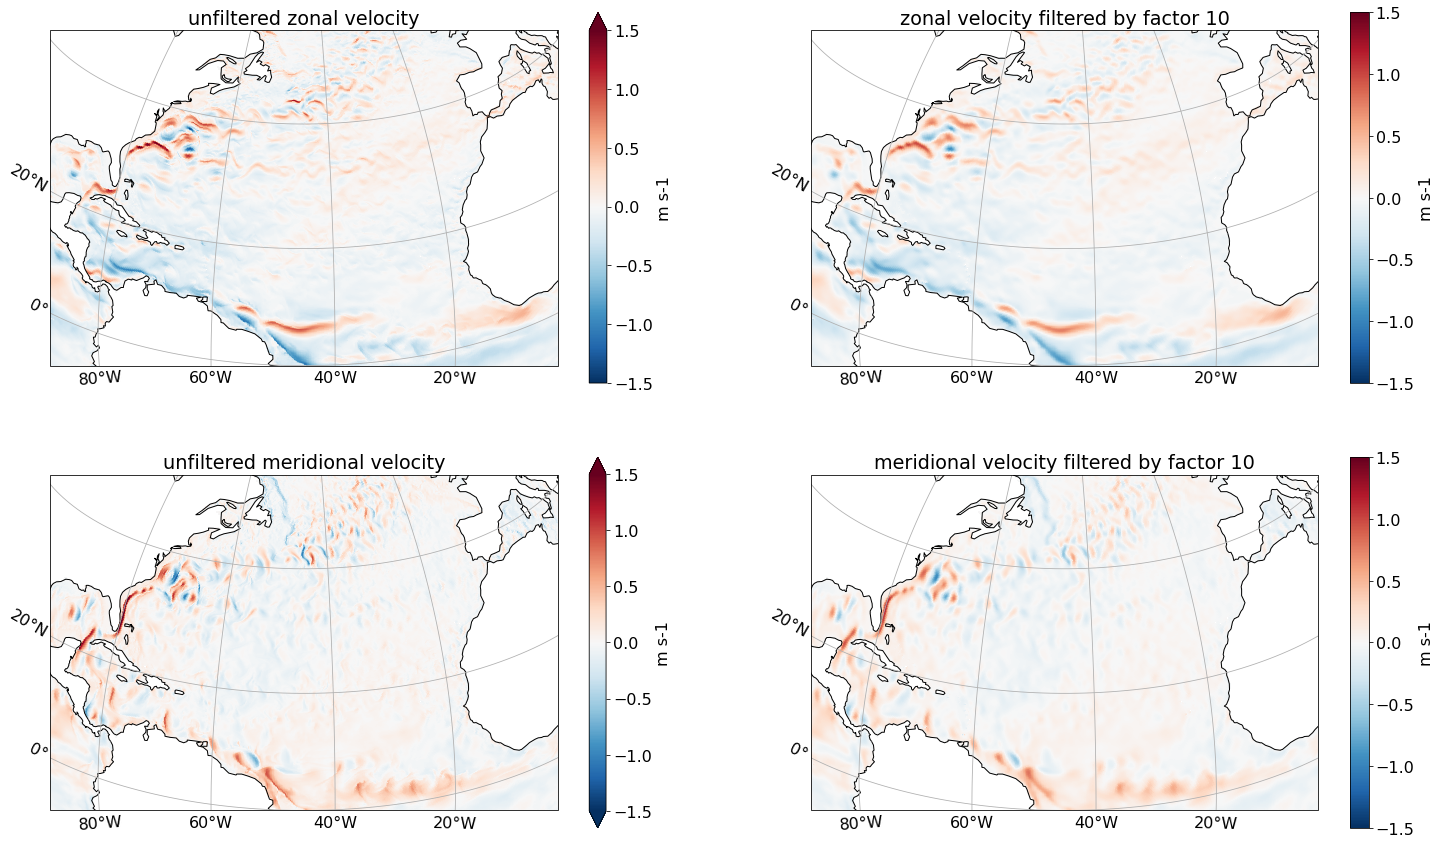

In [35]:
vmax = 1.5
central_lon = -45
central_lat = 30

fig,axs = plt.subplots(2,2,figsize=(25,15),subplot_kw={'projection':ccrs.Orthographic(central_lon, central_lat)})

u.plot(
    ax=axs[0,0], x='geolon', y='geolat', vmin=-vmax, vmax=vmax, 
    cmap='RdBu_r', cbar_kwargs={'label': 'm s-1'},
    transform=ccrs.PlateCarree()
)
v.plot(
    ax=axs[1,0], x='geolon', y='geolat', vmin=-vmax, vmax=vmax, 
    cmap='RdBu_r', cbar_kwargs={'label': 'm s-1'},
    transform=ccrs.PlateCarree()
)
u_filtered_fac10.plot(
    ax=axs[0,1], x='geolon', y='geolat', vmin=-vmax, vmax=vmax, 
    cmap='RdBu_r', cbar_kwargs={'label': 'm s-1'},
    transform=ccrs.PlateCarree()
)
v_filtered_fac10.plot(
    ax=axs[1,1], x='geolon', y='geolat', vmin=-vmax, vmax=vmax, 
    cmap='RdBu_r', cbar_kwargs={'label': 'm s-1'},
    transform=ccrs.PlateCarree()
)

axs[0,0].set(title='unfiltered zonal velocity')
axs[0,1].set(title='zonal velocity filtered by factor 10')
axs[1,0].set(title='unfiltered meridional velocity')
axs[1,1].set(title='meridional velocity filtered by factor 10')

for ax in axs.flatten():
    ax.coastlines()
    ax.set_extent([-90, 0, 0, 50], crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True)
    gl.xlocator = mticker.FixedLocator([-80,-60,-40,-20])
    gl.ylocator = mticker.FixedLocator([0,20,40,60])
    gl.top_labels = False
    gl.right_labels = False
